In [1]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
import copy                               # for deep copies
import warnings
import json
import properscoring as ps
import random

In [2]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.dataset.util import to_pandas
from gluonts.evaluation import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from gluonts.dataset.field_names import FieldName

from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
import scipy
import logging

In [3]:
#Display all of the rows in a dataframe
pd.set_option('display.max_rows', 10000)
warnings.filterwarnings("ignore")
sc = MinMaxScaler()
sens_analysis = False
pred_len = 60

In [11]:
filename = os.path.abspath('') + '\\Data\\Filtered\\FilteredProduction.xlsx'
file = open(filename, "rb")
prodDF = pd.read_excel(file, engine="openpyxl")

filename = os.path.abspath('') + '\\Data\\Filtered\\FilteredInjection.xlsx'
file = open(filename, "rb")
injectDF = pd.read_excel(file, engine="openpyxl")

filename = "LongestProductionWells.xlsx"
filename = os.path.abspath('') + "\\Data\\Use\\" + filename
file = open(filename, "rb")
testDF = pd.read_excel(file, engine='openpyxl')

In [13]:
#Filter to one well
use_well = "43-29A-H Brown"
use_unit = "Central Buffalo Red River Unit"

p_units = prodDF.groupby(prodDF.Well_Name)
prodDF = p_units.get_group(use_well)

i_units = injectDF.groupby(injectDF.Enhanced_Recovery_Unit)
injectDF = i_units.get_group(use_unit)

In [26]:
###########    Injection by Unit     #########
p_units = prodDF.groupby(prodDF.Enhanced_Recovery_Unit)
i_units = injectDF.groupby(injectDF.Enhanced_Recovery_Unit)

In [27]:
def run_unit(name, p_unit, i_unit):
    #Group dataset by well
    well_groups = p_unit.groupby(p_unit.Well_Name)
    well_names = []
    wells = []
    
    prod_Data_Vol = 0
    inj_Data_Vol = 0
    
    for well, data in well_groups:
        well_names.append(well)
        if (len(data) > pred_len):
            wells.append(data)
            prod_Data_Vol += len(well)
    
    i_well_groups = i_unit.groupby(["Well_Name"])
    i_wells = []
    for i_well, data in i_well_groups:
        i_wells.append(data)
        inj_Data_Vol += len(i_well)
            
    train_list = []
    test_list = []
    for x in wells:
        length = x.Oil_bbls.size

        covar_train = []
        covar_test = []

        for i in i_wells:            #Injection: all wells
            i_well = i
            i_well = i_well.set_index(i_well.Date_Injection_Report)
            i_well = i_well[~i_well.index.duplicated()]
            
            i_well = i_well.reindex(x.Date_Production, fill_value=0)

            if (sens_analysis):
                #Set the test injection covariate values (to see effect)
                ratio = 1.0    #Proportion to set all test injection values to
                i_well.Vol_Fluid_Injected[int(length - pred_len):] = max(i_well.Vol_Fluid_Injected) * ratio

            #series = sc.fit_transform(i_well.Vol_Fluid_Injected.values.reshape(-1, 1))
            #series = series.reshape(1, -1)[0]
            #covar_train.append(series[:int(length - pred_len)])
            #covar_test.append(series)
            covar_train.append(i_well.Vol_Fluid_Injected[:int(length - pred_len)])
            covar_test.append(i_well.Vol_Fluid_Injected)
            
            
        #covar_train = sc.fit_transform(covar_train)
        #covar_test = sc.fit_transform(covar_test)

        prod_days = sc.fit_transform(x.Prod_Days.values.reshape(-1, 1))
        prod_days = prod_days.reshape(1, -1)[0]

        np.insert(covar_train, 0, prod_days[:int(length - pred_len)])
        np.insert(covar_test, 0, prod_days)

        train_list.append({
            'target': x.Oil_bbls[:int(length - pred_len)],
            'start': x.iloc[0].Date_Production,
            'feat_dynamic_real': covar_train
        })
        test_list.append({
            'target': x.Oil_bbls,
            'start': x.iloc[0].Date_Production,
            'feat_dynamic_real': covar_test
        })
    train_ds = ListDataset(train_list, freq="1M")
    test_ds = ListDataset(test_list, freq="1M")
    
    estimator = DeepAREstimator(freq="1M", prediction_length=pred_len, trainer=Trainer(epochs=25),
                                    #, learning_rate=.001,
                                    #num_batches_per_epoch=50), 
                                    use_feat_dynamic_real=True)  #Tuning without Injection!!!
                                    #num_cells=40, num_layers=1, dropout_rate=.6, batch_size=32,
                                    #context_length=30, cell_type='lstm')


    predictor = estimator.train(training_data=train_ds)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=10,  # number of sample paths we want for evaluation          #Tune this value???
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)
    
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(train_ds))
    
    crps_list = []
    for i in range(len(tss)):
        crps = ps.crps_ensemble(tss[i][(len(tss[i]) - pred_len):][0].values, np.transpose(forecasts[i].samples)).mean()
        crps_list.append(crps)

    item_metrics['Mean CRPS'] = crps_list
    item_metrics['RMSE'] = item_metrics['MSE']**(.5)
    agg_metrics['Mean CRPS'] = sum(crps_list)/len(crps_list)
    aggDF = pd.DataFrame([agg_metrics])
    
    ret_DF = {"Unit_Name":name, "Inj_Data_Vol":inj_Data_Vol, "Prod_Data_Vol":prod_Data_Vol,
              "agg_DF":aggDF, "forecasts":forecasts, "tss":tss, "agg_metrics":agg_metrics, "item_metrics":item_metrics}
    return ret_DF

In [28]:
results = []
for name, data in p_units:
    random.seed(42)
    if (name in ["Alum Creek Unit", "Buffalo Red River Unit", "Central Buffalo Red River Unit",
                "East Harding Springs Red River Unit", "North Buffalo Red River Unit",
                "Pete's Creek Red River Unit", "South Buffalo Red River Unit",
                "West Buffalo B Red River Unit", "West Buffalo Red River Unit"]):
        
        logging.warning(" Running Unit: " + name) 
        p_unit = p_units.get_group(name)
        i_unit = i_units.get_group(name)
        results.append(run_unit(name, p_unit, i_unit))

Running evaluation: 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 200.00it/s]


In [29]:
results_list = []
for x in results:
    results_list.append({"Unit Name":x["Unit_Name"], "Inj Data Volume":x['Inj_Data_Vol'],
                         "Prod Data Volume":x['Prod_Data_Vol'], "MAPE":x['agg_metrics']['MAPE'],
                          "mCRPS":x['agg_metrics']['Mean CRPS']})
results_DF = pd.DataFrame(results_list)

In [30]:
results_DF

,Unit Name,Inj Data Volume,Prod Data Volume,MAPE,mCRPS
0,Central Buffalo Red River Unit,61,14,0.701181,353.644165


In [31]:
#results_Copy = results_DF
#results_DF_Copy = results_DF
results_DF_Copy

NameError: name 'results_DF_Copy' is not defined

In [ ]:
well_names = []
well_groups = prodDF.groupby(prodDF.Well_Name)
for well, data in well_groups:
    well_names.append(well)

In [ ]:
plt.scatter(x=results_DF.Prod_Data_Vol + results_DF.Inj_Data_Vol, y=results_DF.MAPE)

In [32]:
def plot_prob_forecasts(ts_entry, forecast_entry, well_name):
    plot_length = 200
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.15, top=1.0, wspace=0.2, hspace=0.2)
    plt.grid(which="both")
    plt.legend(legend, loc="upper right")
    plt.xlabel('year')
    plt.ylabel('Oil bbls')
    plt.title("+Injection " + well_name + " Forecast")
    plt.show()

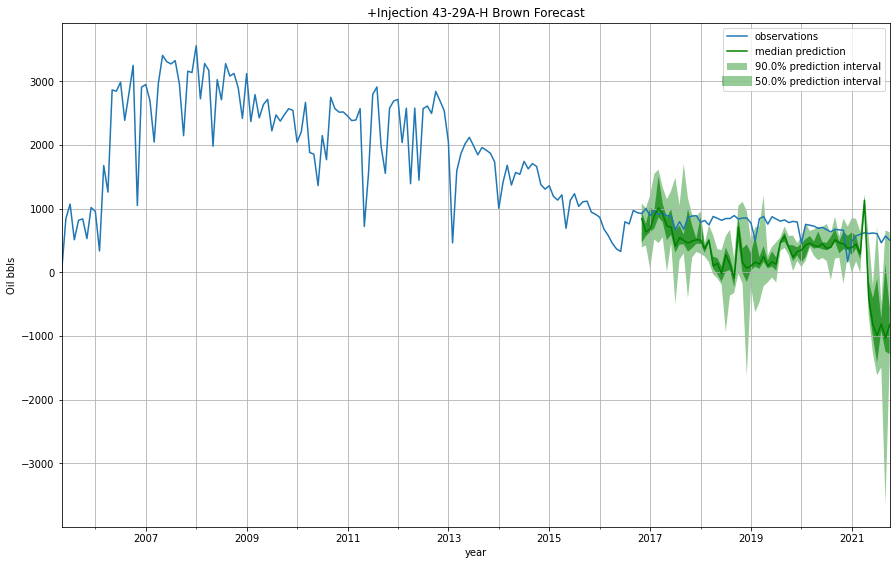

In [33]:
for i in range(len(results[0]['tss'])):
    #if well_names[i] == "I-28H McKitrick": #in test_wells:
    plot_prob_forecasts(results[0]['tss'][i], results[0]['forecasts'][i], well_names[i])       

In [67]:
aggDict = {'MAPE':round(agg_metrics['MAPE'], 3), 
           'Mean CRPS':round(agg_metrics['Mean CRPS'], 4)}
aggDF = pd.DataFrame([aggDict])
aggDF

,MAPE,Mean CRPS
0,1.212,165.7567


In [68]:
#1.087	111.9364

In [69]:
top_metrics = []
for i in range(len(item_metrics)):
    item_metrics.item_id[i] = well_names[i]
    if well_names[i] in test_wells:
        top_metrics.append(item_metrics.iloc[i])
top_metrics_DF = pd.DataFrame(top_metrics)
top_metrics_DF.drop(columns=['MSE', 'abs_target_sum', 'MSIS', 'QuantileLoss[0.1]',
                            'QuantileLoss[0.5]', 'QuantileLoss[0.9]', 'seasonal_error', 'MASE', 'sMAPE', 'abs_error',
                            'Coverage[0.1]', 'Coverage[0.5]', 'Coverage[0.9]'])
top_metrics_DF = top_metrics_DF.rename(columns={"item_id": "Well Name", "abs_target_mean": "Mean Oil bbls"})
top_metrics_DF = top_metrics_DF[['Well Name', 'Mean Oil bbls', 'RMSE', 'Mean CRPS', 'MAPE']]
top_metrics_DF

,Well Name,Mean Oil bbls,RMSE,Mean CRPS,MAPE
57,SBRRU 14-28,428.233333,269.027647,156.256348,6.518790
74,SBRRU 34-11,774.333333,281.243163,161.389297,0.331082
